# Experimento I : Validación del artículo "A Preliminary Study on Deep Transfer Learning Applied to Image Classification for Small Datasets".

En este experimiento usaremos la infraestructura planteada para comprobar si las ideas del artículo "A Preliminary Study on Deep Transfer Learning Applied to Image Classification for Small Datasets" se validan en un problema multiclase.

## Librerías usadas.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from glob import glob
from matplotlib import pyplot as plt
import os
import tensorflow as tf
from tqdm import tqdm
import cv2
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils import resample

## Parámetros globales

In [2]:
#Rutas de los datos.
 
data_dir = os.path.dirname(os.path.realpath("../TFG/Datos/HAM10000_metadata.csv"))



csv_path = os.path.realpath(data_dir + "/HAM10000_metadata.csv")

#Variables globales

altura = 50
longitud = 50
clases = 7


print(data_dir)

print(csv_path)



/home/antoniojesus/Escritorio/TFG/Datos
/home/antoniojesus/Escritorio/TFG/Datos/HAM10000_metadata.csv


## Creación del marco de datos.

In [3]:
#Inicializando el dataFrame

dataFrame=pd.read_csv(csv_path)

#Mezclando carpetas.

all_image_path = glob(os.path.join(data_dir, '*', '*'))
imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x for x in all_image_path}

# Inicializando diccionario de categorías

lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

#Añadiendo columnas al dataFrame para que sea más legible.

dataFrame['path'] = dataFrame['image_id'].map(imageid_path_dict.get)
dataFrame['cell_type'] = dataFrame['dx'].map(lesion_type_dict.get) 
dataFrame['cell_type_idx'] = pd.Categorical(dataFrame['cell_type']).codes
dataFrame.head()


,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,/home/antoniojesus/Escritorio/TFG/Datos/HAM100...,Benign keratosis,2
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,/home/antoniojesus/Escritorio/TFG/Datos/HAM100...,Benign keratosis,2
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,/home/antoniojesus/Escritorio/TFG/Datos/HAM100...,Benign keratosis,2
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,/home/antoniojesus/Escritorio/TFG/Datos/HAM100...,Benign keratosis,2
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,/home/antoniojesus/Escritorio/TFG/Datos/HAM100...,Benign keratosis,2


## Select_network

Este método permite seleccionar la parte superior de una red.

In [4]:
def select_network(nn_base_arch):

    if nn_base_arch =='CNN_SOCO':
        nn = cnn_soco()
        
    return nn

## Los métodos que se describen acontinuación permitirán crear diferentes tipos de capas superiores que se usarán en el método select_network. Los métodos son : 

 - cnn_soco = Es una réplica de la red usada en el estudio "A Preliminary Study on Deep Transfer Learning Applied to Image Classification for Small Datasets".


In [5]:
def cnn_soco():
    
    model = tf.keras.Sequential()
    
    model.add(tf.keras.layers.Conv2D(32, (3,3),(1,1), activation='relu',input_shape=(altura,longitud,3)))
    model.add(tf.keras.layers.Conv2D(32, (3,3),(1,1),activation='relu'))
    model.add(tf.keras.layers.MaxPooling2D((2,2)))

 
    model.add(tf.keras.layers.Conv2D(64, (3,3), activation='relu'))
    model.add(tf.keras.layers.MaxPooling2D((2,2)))
    
    return model

Los métodos que se describen a continuación generarán la capa de salida de nuestra red : 
 - build : Modificación de la anterior, añadimos una capa de BachNormalization

In [6]:
def build(nn):
    model = tf.keras.Sequential()
    model.add(nn)
    model.add(tf.keras.layers.Flatten())
    
    model.add(tf.keras.layers.Dense(128))
    model.add(tf.keras.layers.Activation('relu'))

    model.add(tf.keras.layers.Dense(clases,activation='softmax'))


    return model

def build_dense(nn):
    model = tf.keras.Sequential()
    model.add(nn)
    model.add(tf.keras.layers.Flatten())
    
    model.add(tf.keras.layers.Dense(1024))
    model.add(tf.keras.layers.Activation('relu'))
    
    model.add(tf.keras.layers.Dense(1024))
    model.add(tf.keras.layers.Activation('relu'))

    model.add(tf.keras.layers.Dense(clases,activation='softmax'))

    return model

In [7]:
nn = select_network('CNN_SOCO')
model = build(nn)

## Se procede a crear un método que permita balancear la carga de imágenes

In [8]:
def balanced_dataset(df):
    df_balanced = pd.DataFrame()
    #df = pd.DataFrame()
    
    for cat in df['cell_type_idx'].unique():
        temp = resample(df[df['cell_type_idx'] == cat], 
                        replace=True,     # sample with replacement
                        n_samples=2500,   # to match majority class
                        random_state=123) # reproducible results

        # Combine majority class with upsampled minority class
        df_balanced = pd.concat([df_balanced, temp])
 
    df_balanced['cell_type'].value_counts()

    return df_balanced

def load_img_data(size, df, balanced=False):
    """
        ..
        first we should normalize the image from 0-255 to 0-1
    """
    
    img_h, img_w = size, size
    imgs = []
    
    if balanced:
        df = balanced_dataset(df)
    
    image_paths = list(df['path'])

    for i in tqdm(range(len(image_paths))):
        img = cv2.imread(image_paths[i])
        img = cv2.resize(img, (img_h, img_w))
        img = img.astype(np.float32) / 255.
        #img = np.asarray(Image.open(image_paths[i]).resize((size,size)))
        imgs.append(img)

    imgs = np.stack(imgs, axis=0)
    print(imgs.shape)

    #imgs = imgs.astype(np.float32) / 255.
    
    return imgs, df['cell_type_idx'].values

In [ ]:
del dataFrame
del imgs
del target
del x_train
del x_test
del y_train
del y_test
del x_val
del y_val

## Cargamos los datos y generamos el set de datos,entrenamiento y validación.

In [21]:
def load_general_data():
    
    imgs, target = load_img_data(altura, dataFrame, balanced=True)
    
    x_train, x_transferLearning, y_train, y_transferLearning = train_test_split(imgs, target, test_size=0.60)
       
    source_data = [ x_transferLearning , y_transferLearning ]
    target_data = [ x_train , y_train ]
    
    x_train,x_test,y_train,y_test = train_test_split(target_data[0], target_data[1], test_size=0.70)
    
    train_data = [x_train,y_train]
    test_data = [x_test,y_test]
    
    return source_data,train_data,test_data


def get_data_for_ex_1(source_data,train_data,test_data):
    
    x_train = train_data[0]
    y_train = train_data[1]
    
    x_test = test_data[0]
    y_test = test_data[1]
    
    return x_train,x_test,y_train,y_test


def get_data_for_ex_2(source_data,train_data,test_data):
    
    x_train = source_data[0]
    y_train = source_data[1]
    
    x_test = test_data[0]
    y_test = test_data[1]
    
    return x_train,x_test,y_train,y_test


def get_data_for_ex_3(source_data,train_data,test_data):
    data_0 = source_data[0]
    data_1 = source_data[1]
    
    for e in train_data[0]:
        np.append(data_0,e)
        
    for e in train_data[1]:
        np.append(data_1,e)
        
    x_train = data_0
    y_train = data_1
    
    x_test = test_data[0]
    y_test = test_data[1]
    
    return x_train,x_test,y_train,y_test


def get_data_for_ex_4(source_data,train_data,test_data):
    
    x_train = source_data[0]
    y_train = source_data[1]
    
    x_retrain = train_data[0]
    y_retrain = train_data[1]
    
    x_test = test_data[0]
    y_test = test_data[1]
    
    return x_train,x_retrain,x_test,y_train,y_retrain,y_test


In [10]:
#Constantes
BATCH_SIZE = 128
EPOCHS = 5

RMSpropEstudio = tf.keras.optimizers.RMSprop(
    learning_rate=0.0001
)

In [11]:
source_data,train_data,test_data = load_general_data()

100%|██████████| 17500/17500 [04:38<00:00, 62.91it/s] 


(17500, 50, 50, 3)


In [26]:
x_train,x_retrain,x_test,y_train,y_retrain,y_test = get_data_for_ex_4(source_data,train_data,test_data)
res4,res5,evaluations4,evaluations5 = run_experiment_4(nn_base_arch,EPOCHS)

154/154 [==============================] - 2s 12ms/step - loss: 2.1275 - accuracy: 0.2394 - mse: 11.8938
--------------------------------------------------------------------------
154/154 [==============================] - 2s 12ms/step - loss: 1.4038 - accuracy: 0.4324 - mse: 11.9013
########################################################
Iteración 1 de 10
########################################################
154/154 [==============================] - 2s 11ms/step - loss: 1.5087 - accuracy: 0.3916 - mse: 11.8841
--------------------------------------------------------------------------
154/154 [==============================] - 2s 11ms/step - loss: 1.3913 - accuracy: 0.4465 - mse: 11.8935
########################################################
Iteración 2 de 10
########################################################
154/154 [==============================] - 2s 13ms/step - loss: 1.3727 - accuracy: 0.4720 - mse: 11.8776
-------------------------------------------------------------

In [ ]:
x_train,x_test,y_train,y_test = get_data_for_ex_1(source_data,train_data,test_data)
res1,evaluations1 = run_experiment_1_2_and_3(nn_base_arch,EPOCHS)

x_train,x_test,y_train,y_test = get_data_for_ex_2(source_data,train_data,test_data)
res2,evaluations2 = run_experiment_1_2_and_3(nn_base_arch,EPOCHS)

In [23]:




x_train,x_test,y_train,y_test = get_data_for_ex_3(source_data,train_data,test_data)
res3,evaluations3 = run_experiment_1_2_and_3(nn_base_arch,EPOCHS)




plot_acc_for_ex1_w_test_score(res1,evaluations1,EPOCHS,"Experiment 1")
plot_acc_for_ex1_w_test_score(res2,evaluations2,EPOCHS,"Experiment 2")
plot_acc_for_ex1_w_test_score(res3,evaluations3,EPOCHS,"Experiment 3")


154/154 [==============================] - 2s 14ms/step - loss: 1.4749 - accuracy: 0.4029 - mse: 11.8794
########################################################
Iteración 1 de 10
########################################################
154/154 [==============================] - 2s 12ms/step - loss: 1.5864 - accuracy: 0.3627 - mse: 11.8852
########################################################
Iteración 2 de 10
########################################################
154/154 [==============================] - 2s 12ms/step - loss: 1.5105 - accuracy: 0.3769 - mse: 11.8865
########################################################
Iteración 3 de 10
########################################################
154/154 [==============================] - 2s 14ms/step - loss: 1.5865 - accuracy: 0.3700 - mse: 11.8894
########################################################
Iteración 4 de 10
########################################################
154/154 [==============================] - 2s 13ms/s

NameError: name 'plot_acc_for_ex1_w_test_score' is not defined

In [17]:
def run_train(nn_base_arch,epochs,checkpoint,dense = False):
    nn = select_network(nn_base_arch)
    
    if dense == True :
        model = build_dense(nn)
    else:
        model = build(nn)
        
    cpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint, monitor="loss", mode="min", save_best_only=True, verbose=0)
    model.compile(loss='sparse_categorical_crossentropy', optimizer=RMSpropEstudio, metrics=['accuracy','mse'])
    
    history = model.fit(x_train, y_train,epochs=EPOCHS,callbacks=[cpoint],batch_size = BATCH_SIZE,verbose=0)
      
    evaluation = model.evaluate(x_test, y_test)
        
    return history,evaluation

def run_train_w_model(nn_base_arch,epochs,checkpoint,dense = False):
    nn = select_network(nn_base_arch)
    
    if dense == True :
        model = build_dense(nn)
    else:
        model = build(nn)
        
    cpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint, monitor="loss", mode="min", save_best_only=True, verbose=0)
    model.compile(loss='sparse_categorical_crossentropy', optimizer=RMSpropEstudio, metrics=['accuracy','mse'])
    
    history = model.fit(x_train, y_train,epochs=EPOCHS,callbacks=[cpoint],batch_size = BATCH_SIZE,verbose=0)
      
    evaluation = model.evaluate(x_test, y_test)
        
    return history,evaluation,model

def re_train(model,epocas):
    #checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint, monitor="loss", mode="min", save_best_only=True, verbose=0)
    history = model.fit(x_train, y_train,epochs=EPOCHS,batch_size = BATCH_SIZE,verbose=0)
    evaluation = model.evaluate(x_test, y_test)
    return history,evaluation

In [ ]:
def run_train(nn_base_arch,epochs,checkpoint,dense = False):
    nn = select_network(nn_base_arch)
    
    if dense == True :
        model = build_dense(nn)
    else:
        model = build(nn)
        
    checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint, monitor="loss", mode="min", save_best_only=True, verbose=0)
    model.compile(loss='sparse_categorical_crossentropy', optimizer=RMSpropEstudio, metrics=['accuracy','mse'])
    
    history = model.fit(x_train, y_train,epochs=EPOCHS,callbacks=[checkpoint],batch_size = BATCH_SIZE,verbose=0)
      
    evaluation = model.evaluate(x_test, y_test)
        
    return history,evaluation

In [15]:
nn_base_arch = "CNN_SOCO"


def run_experiment_1_2_and_3(nn_base_arch,epochs,dense = False):
    result = []
    evaluations = []
    for i in range(10):
        checkpoint ="../TFG/Modelos/balanced_model_"+nn_base_arch+"_exp1_v_"+str(i)+"_EXP0.h5"
        h,e = run_train(nn_base_arch,epochs,checkpoint,dense = False)
        result.append(h)
        evaluations.append(e)
        print("########################################################")
        print("Iteración "+str(i+1) +" de 10")
        print("########################################################")
        
    return result,evaluations


def run_experiment_4(nn_base_arch,epochs,dense = False):
    result = []
    result_post_tf = []
    evaluations = []
    evaluations_post_tf = []
    for i in range(10):
        checkpoint ="../TFG/Modelos/balanced_model_"+nn_base_arch+"_exp4_v_"+str(i)+"_EXP0.h5"
        h,e,tf_model = run_train_w_model(nn_base_arch,epochs,checkpoint,dense = False)
        result.append(h)
        evaluations.append(e)
        
        print("--------------------------------------------------------------------------")

        layers = tf_model.layers[0:-1]
        for layer in layers:
            layer.trainable = False
        
        h_retrain,e_retrain = re_train(tf_model,epochs)
        
        result_post_tf.append(h_retrain)
        evaluations_post_tf.append(e_retrain)
        
        
        
        print("########################################################")
        print("Iteración "+str(i+1) +" de 10")
        print("########################################################")
        
    return result,result_post_tf,evaluations,evaluations_post_tf
    

In [ ]:
res1,evaluacion1 = run_experiment_1_2_and_3(nn_base_arch,EPOCHS)

In [ ]:
res1,evaluacion1 = run_experiment_2(nn_base_arch,EPOCHS)

In [ ]:
print(evaluacion[1])

In [ ]:
plot_acc_for_ex1_w_test_score(res,evaluacion,EPOCHS,"Cosas")

In [15]:
def plot_acc_for_ex1_w_test_score(res,evaluations,epochs,name):
    plt.figure(figsize=(12,8))
    
    for i in range(len(res)):
        precisiones=[]
        precisiones.append(0.0)
        for e in res[i].history["accuracy"]:
            precisiones.append(e)
            
        plt.plot(np.arange(0, epochs+1), precisiones[0:epochs+1], label="train_acc")
        plt.plot(5,evaluations[i][1],'bo')
        
    plt.title("Training Loss and Accuracy - {}".format(name))
    plt.xlabel("Epoch #")
    plt.ylabel("Loss/Accuracy")
    plt.legend()
    plt.show()

In [ ]:
def plot_acc_for_ex1(res,epochs,name):
    plt.figure(figsize=(12,8))
    
    for i in range(len(res)):
        precisiones=[]
        precisiones.append(0.0)
        for e in res[i].history["accuracy"]:
            precisiones.append(e)
            
        plt.plot(np.arange(0, epochs+1), precisiones[0:epochs+1], label="train_acc")
    plt.title("Training Loss and Accuracy - {}".format(name))
    plt.xlabel("Epoch #")
    plt.ylabel("Loss/Accuracy")
    plt.legend()
    plt.show()

In [16]:
def plot_acc_for_experiments(res,res1,evaluations,evaluations1,epochs,name):
    plt.figure(figsize=(12,8))
    
    for i in range(len(res)):
        precisiones=[]
        precisiones.append(0.0)
        for e in res[i].history["accuracy"]:
            precisiones.append(e)
        
        precisiones1=[]
        precisiones1.append(0.0)
        for e in res1[i].history["accuracy"]:
            precisiones1.append(e)
        
        if i == 0:
            plt.plot(np.arange(0, epochs+1), precisiones[0:epochs+1], label="train_acc",color='green')
            plt.plot(np.arange(0, epochs+1), precisiones1[0:epochs+1], label="train_acc",color='blue')
        else:
            plt.plot(np.arange(0, epochs+1), precisiones[0:epochs+1],color='green')
            plt.plot(np.arange(0, epochs+1), precisiones1[0:epochs+1],color='blue')
            plt.plot(5,evaluations[i][1],'bo',color='green')
            plt.plot(5,evaluations1[i][1],'bo',color='blue')
        
    plt.title("Training Loss and Accuracy - {}".format(name))
    plt.xlabel("Epoch #")
    plt.ylabel("Loss/Accuracy")
    plt.legend()
    plt.show()

In [78]:
def plot_acc_all_experiments(res,res1,res2,res3,evaluations,evaluations1,evaluations2,evaluations3,epochs):
    plt.figure(figsize=(16,10))
    
    for i in range(len(res)):
        
        precisiones=[]
        precisiones.append(0.0)
        for e in res[i].history["accuracy"]:
            precisiones.append(e)
        
        precisiones1=[]
        precisiones1.append(0.0)
        for e in res1[i].history["accuracy"]:
            precisiones1.append(e)
            
        precisiones2=[]
        precisiones2.append(0.0)
        for e in res2[i].history["accuracy"]:
            precisiones2.append(e)
        
        precisiones3=[]
        precisiones3.append(0.0)
        for e in res3[i].history["accuracy"]:
            precisiones3.append(e)
            
        
        if i == 0:
            plt.plot(np.arange(0, epochs+1), precisiones[0:epochs+1], label="exp_1",color='green')
            plt.plot(np.arange(0, epochs+1), precisiones1[0:epochs+1], label="exp_2",color='blue')
            plt.plot(np.arange(0, epochs+1), precisiones2[0:epochs+1], label="exp_3",color='brown')
            plt.plot(np.arange(0, epochs+1), precisiones3[0:epochs+1], label="exp_4",color='salmon')
        else:
            plt.plot(np.arange(0, epochs+1), precisiones[0:epochs+1],color='green')
            plt.plot(np.arange(0, epochs+1), precisiones1[0:epochs+1],color='blue')
            plt.plot(np.arange(0, epochs+1), precisiones2[0:epochs+1],color='brown')
            plt.plot(np.arange(0, epochs+1), precisiones3[0:epochs+1],color='salmon')

        
    plt.title("Training Accuracy and Test Results")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss/Accuracy")
    plt.legend()
    plt.savefig("Exp_0_Results.jpg")
    plt.show()
    

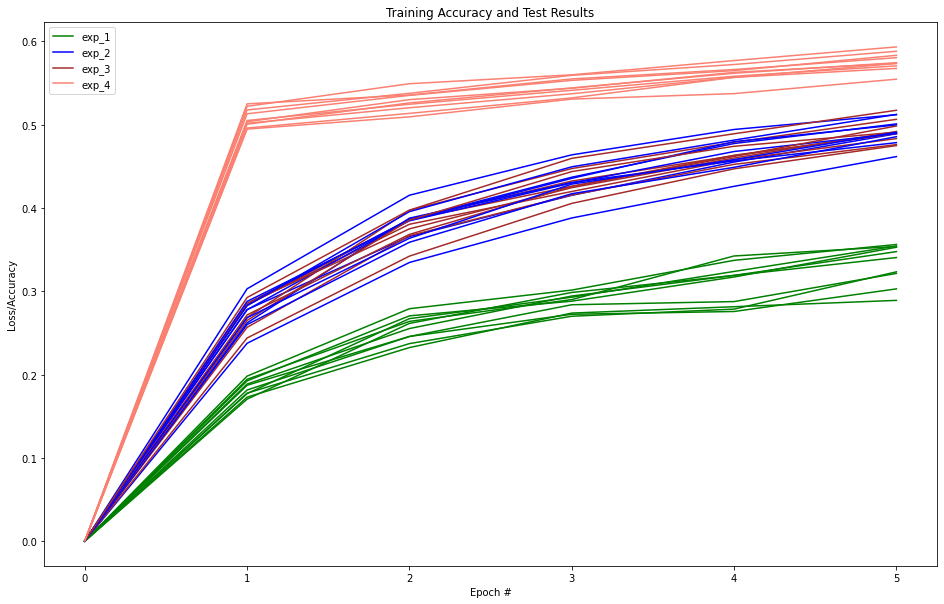

In [79]:
plot_acc_all_experiments(res1,res2,res3,res5,evaluations1,evaluations2,evaluations3,evaluations5,EPOCHS)

In [77]:
#res1,res2,res3,res4,evaluations1,evaluations2,evaluations3,evaluations4

precision1 = []
precision2 = []
precision3 = []
precision4 = []

for e in evaluations1:
    element = e[1]
    precision1.append(element)

for e in evaluations2:
    element = e[1]
    precision2.append(element)

for e in evaluations3:
    element = e[1]
    precision3.append(element)

for e in evaluations5:
    element = e[1]
    precision4.append(element)

    
    
d = {'Iteración':[1,2,3,4,5,6,7,8,9,10],'Precision 1': precision1,'Precision 2': precision2,'Precision 3': precision3,'Precision 4': precision4}
df = pd.DataFrame(data=d)

print(df.mean(0))

print(df['Precision 4'])

Iteración      5.500000
Precision 1    0.333837
Precision 2    0.385735
Precision 3    0.351204
Precision 4    0.435306
dtype: float64
0    0.432449
1    0.446531
2    0.473878
3    0.337959
4    0.428163
5    0.443673
6    0.503878
7    0.350612
8    0.454898
9    0.481020
Name: Precision 4, dtype: float64
